<h2>Features to be removed</h2>
<ul>
  <li>Crimes
    <ul>
      <li>Crime ID (now)</li>
      <li>Context (now)</li>
      <li>LSOA code (future)</li>
      <li>Falls Within (future)</li>
    </ul>
  </li>

  <li>Prices
    <ul>
      <li>LatestData (now)</li>
      <li>DurationFrom (now)</li>
      <li>DurationTo (now)</li>
      <li>OrganisationLabel (future)</li>
      <li>PublishedDate (future)</li>
      <li>OrganisationURI (future)</li>
    </ul>
  </li>
</ul>


In [ ]:
%%capture
!pip install duckdb
!pip install ipython-sql
!pip install SQLAlchemy
!pip install duckdb-engine

<h2>Drive Mount</h2>

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


<h2>Imports & Setup</h2>

In [ ]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from datetime import datetime as dt
import glob

# Import ipython-sql Jupyter extension to create SQL cells
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: UserWarning: Config option `displaycon` not recognized by `SqlMagic`.  Did you mean `displaylimit`?
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# %sql duckdb:////content/drive/MyDrive/ADSDBProject/formatted/crimesPrices.db
# to use a database file (shared between processes)

mostRecent = glob.glob("/content/drive/MyDrive/ADSDBProject/trusted/*.db")[-1]
con = duckdb.connect(database=mostRecent)

<h2>Import Tables</h2>

In [ ]:
crimes = con.execute("SELECT * FROM crimes").df()
prices = con.execute("SELECT * FROM prices").df()

<h2>NAs</h2>

In [ ]:
print("Crimes features with NA values")
print("-------------------------------")
print(crimes.isnull().sum())
print("Crimes size: ", len(crimes))

print()
print()

print("Prices features with NA values")
print("-------------------------------")
print(prices.isnull().sum())
print("Prices size: ", len(prices))

Crimes features with NA values
-------------------------------
Crime ID                 23329
Month                        0
Reported by                  0
Falls within                 0
Longitude                    0
Latitude                     0
Location                     0
LSOA code                    1
LSOA name                    1
Crime type                   0
Last outcome category    23329
Context                  79004
dtype: int64
Crimes size:  79004


Prices features with NA values
-------------------------------
OrganisationLabel                0
OrganisationURI                  0
PublishedDate                    0
LatestData                      88
DurationFrom                     0
DurationTo                       0
ReportingPeriodType              0
Month                            0
GeoEntityName                    0
GeoCode                          0
GeoName                          0
GeoURI                           0
AveragePrice                     0
AveragePrice

<h4>Crimes NAs</h4>
<p>To start with, the "Context" feature is empty for every instance of the crime dataset. Therefore, we will remove it because there is no way we can impute this without additional information. <br>

"Crime ID" will also be removed, not necessarily because of the number of null values but because it isn't a variable that offers us much information. From a brief look at the dataset, it seems that crimes due to antisocial behaviour don't have a crime ID. Also, it looks like those instaces that don't have a crime ID, have an null value for "Last Outcome Category". This could be because it hard to keep track of the outcome of the arrest if we don't have the crime ID. <br>

Then, we have an NA for both "LSOA code" and "LSOA name". It is likely that they belong to the same instance. We will check this below. If this is the case, we should be able to impute these values by looking at the "Longitude" and "Latitude" attributes.</p>

<h4>Prices NAs</h4>
<p>There is only one attribute that has null values. "LatestData" has no value for all the instances, so we will remove it.</p>



In [ ]:
print("Instances with null LSOA code and name")
print("---------------------------------------")
print(crimes[crimes['LSOA code'].isnull()]['LSOA code'])
print(crimes[crimes['LSOA name'].isnull()]['LSOA name'])

Instances with null LSOA code and name
---------------------------------------
19454    NaN
Name: LSOA code, dtype: object
19454    NaN
Name: LSOA name, dtype: object


<p>As we can see, the null value for both "LSOA code" and "LSOA name" are for the same instance. As these two attributes provide us with the same information, we will remove one of them. In particular, we will remove "LSOA code" because we need "LSOA name" to join the crimes dataset with the prices one. However, we will delete "LSOA code" in a future step.</p>

<h2>Data types</h2>

In [ ]:
print("Crimes data types")
print("-"*35)
print(crimes.dtypes)

print()
print()

print("Prices data types")
print("-"*50)
print(prices.dtypes)

Crimes data types
-----------------------------------
Crime ID                  object
Month                     object
Reported by               object
Falls within              object
Longitude                float64
Latitude                 float64
Location                  object
LSOA code                 object
LSOA name                 object
Crime type                object
Last outcome category     object
Context                  float64
dtype: object


Prices data types
--------------------------------------------------
OrganisationLabel                       object
OrganisationURI                         object
PublishedDate                   datetime64[ns]
LatestData                             float64
DurationFrom                    datetime64[ns]
DurationTo                      datetime64[ns]
ReportingPeriodType                     object
Month                                   object
GeoEntityName                           object
GeoCode                                 ob

<p>In the crimes dataset it seems that most of the attributes are categorical. Despite latitude and longitude being floats, we can't consider them to be strictly numerical data. For now, we will treat them as numerical data. However, in future, there are specific transformation we need to apply to get the most out of these attribute.  On the other hand, in prices, we can see there's more of a mix of categorical and numerical data.</p>

<h2>Duplicate Check</h2>


In [ ]:
print("Number of duplicated cases in crimes:", crimes.duplicated(keep=False).sum())
print("Number of duplicated cases in prices:", prices.duplicated(keep=False).sum())

Number of duplicated cases in crimes: 11324
Number of duplicated cases in prices: 0


<p>From an initial point of view it may seem like we have a lot of duplicated instances in the crimes dataset. However, we need to investigate further to figure out whether they are truly duplicated or not. Maybe according to the data we have they are exactly the same, but in real life they are not.</p>

In [ ]:
print("Number duplicated of cases with a null Crime ID:", crimes['Crime ID'][crimes.duplicated(keep=False)].isnull().sum())

Number duplicated of cases with a null Crime ID: 11324


<p>As we can see, all 11324 of the duplicated cases do not have a Crime ID, making it very tough to confirm that they are duplicated cases. Maybe they are cases where multiple individuals have been caught committing the same crime in the same location at the same time.</p>

In [ ]:
print(crimes['Crime type'][crimes.duplicated(keep=False)].unique())
print("Number of null Crime IDs:", crimes['Crime ID'].isnull().sum())
print("Number of null Crime IDs when Crime Type is Anti-social behaviour:", crimes['Crime ID'][crimes['Crime type'] == 'Anti-social behaviour'].isnull().sum())

['Anti-social behaviour']
Number of null Crime IDs: 23329
Number of null Crime IDs when Crime Type is Anti-social behaviour: 23329


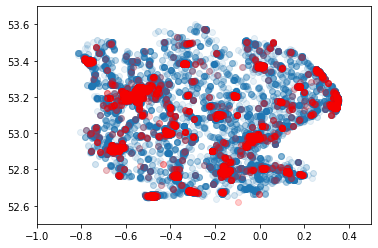

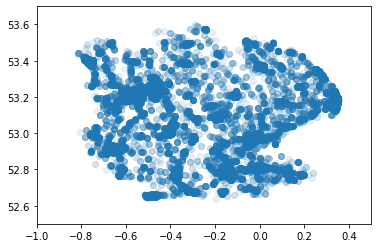

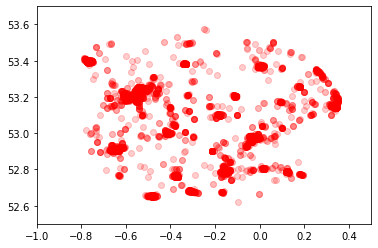

In [ ]:
plt.scatter(x=crimes['Longitude'][~crimes.duplicated(keep=False)], y=crimes['Latitude'][~crimes.duplicated(keep=False)],
            alpha=0.1)
plt.scatter(x=crimes['Longitude'][crimes.duplicated(keep=False)], y=crimes['Latitude'][crimes.duplicated(keep=False)],
            alpha=0.1, c='Red')
plt.xlim(-1, 0.5)
plt.ylim(52.5, 53.7)
plt.show()

plt.scatter(x=crimes['Longitude'][~crimes.duplicated(keep=False)], y=crimes['Latitude'][~crimes.duplicated(keep=False)],
            alpha=0.1)
plt.xlim(-1, 0.5)
plt.ylim(52.5, 53.7)
plt.show()

plt.scatter(x=crimes['Longitude'][crimes.duplicated(keep=False)], y=crimes['Latitude'][crimes.duplicated(keep=False)],
            alpha=0.1, c='Red')
plt.xlim(-1, 0.5)
plt.ylim(52.5, 53.7)
plt.show()

<p>Here we plot the longitude and latitude in the form of a scatterplot of unique crimes (blue) and those crimes that are *duplicated* (red). With this plot we were aiming to see if the *duplicated* crimes were concentraded in certain areas.<br>

From the three plots, it seems that the areas where *duplicated* crimes are more concentrated also seems to be the areas where there are more crimes in general, that is, areas with a relatively high criminal activity.<br>

We can't really confirm that the *duplicate* cases are true duplicates because they could be crimes committed by a group of people. By checking the "Crime ID" of the instances we saw that they were all NA's meaning that from the start we couldn't confirm whether they were duplicates.<br>

Then, we saw that all the *duplicated* cases were of the type "Anti-social bahaviour" which are crimes that tend to be committed in groups.<br>

Finally, we checked were these *duplicate* cases were concentrated in certain areas of Lincolnshire, so a certain district or police station. We checked this because maybe there is a station that is accidentally adding the same crime to the system/dataset multiple times. Or perhaps, they were doing for some other reason that we will not get into (corruption).

In conclusion, despite, according to our data, having 11324 *duplicate* cases, we don't believe we can confirm this. Therefore, we will keep the cases. Perhaps, in future analysis we could use this to provide further insight.
</p> 

<h2>Summary Statistics</h2>

In [ ]:
crimesNum = ['Longitude', 'Latitude']
pricesNum = ['AveragePrice', 'AveragePriceDetached', 'AveragePriceSemiDetached', 'AveragePriceTerraced', 'AveragePriceFlatOrMaisonette']

print("Summary Numerical Crimes")
print("-"*40)
print(crimes[crimesNum].describe())
print("-"*40)
print("Skewness")
print("-"*40)
print(crimes[crimesNum].skew())
print("-"*40)
print("Kurtosis")
print("-"*40)
print(crimes[crimesNum].kurt())

print()
print()

print("Summary Numerical Prices")
print("-"*80)
print(prices[pricesNum].describe())
print("-"*80)
print("Skewness")
print("-"*80)
print(prices[pricesNum].skew())
print("-"*80)
print("Kurtosis")
print("-"*80)
print(prices[pricesNum].kurt())

Summary Numerical Crimes
----------------------------------------
          Longitude      Latitude
count  79004.000000  79004.000000
mean      -0.307530     53.098037
std        0.328329      0.209820
min       -7.882287     52.617902
25%       -0.554016     52.924613
50%       -0.415149     53.165749
75%       -0.030304     53.232820
max        0.849930     54.532164
----------------------------------------
Skewness
----------------------------------------
Longitude    0.362400
Latitude    -0.357843
dtype: float64
----------------------------------------
Kurtosis
----------------------------------------
Longitude    2.648765
Latitude    -0.770770
dtype: float64


Summary Numerical Prices
--------------------------------------------------------------------------------
        AveragePrice  AveragePriceDetached  AveragePriceSemiDetached  \
count      88.000000             88.000000                 88.000000   
mean   212965.068182         285566.352273             188745.261364   
std 

<h2>Categorical Summary</h2>

In [ ]:
print("Crimes attribute unique values")
print("-"*40)
cols = list(set(crimes.columns) - set(crimesNum))
for col in cols:
  print(col)
  print(crimes[col].unique())
  print()
  print()

print()
print()

print("Prices attribute unique values")
print("-"*40)
cols = list(set(prices.columns) - set(pricesNum))
for col in cols:
  print(col)
  print(prices[col].unique())
  print()
  print()

Crimes attribute unique values
----------------------------------------
Month
['2020-06' '2021-02' '2021-03' '2020-07' '2021-04' '2020-08' '2021-05'
 '2020-09' '2021-06' '2020-10' '2020-11' '2020-12' '2021-01']


Location
['On or near Marsh Lane' 'On or near Church Road'
 'On or near Sports/Recreation Area' ... 'On or near Laney Close'
 'On or near Swayne Close' 'On or near Byland Close']


LSOA code
['E01028039' 'E01026007' 'E01026008' 'E01026009' 'E01026023' 'E01026024'
 'E01026010' 'E01026011' 'E01026030' 'E01026032' 'E01026037' 'E01026006'
 'E01026021' 'E01026025' 'E01026036' 'E01026012' 'E01026015' 'E01026026'
 'E01026027' 'E01026028' 'E01026016' 'E01026033' 'E01026034' 'E01026017'
 'E01026018' 'E01026019' 'E01026020' 'E01026041' 'E01026013' 'E01026014'
 'E01026022' 'E01026038' 'E01026040' 'E01026029' 'E01026031' 'E01026035'
 'E01026039' 'E01026045' 'E01026061' 'E01026062' 'E01026063' 'E01026080'
 'E01026106' 'E01026107' 'E01026058' 'E01026076' 'E01026079' 'E01026077'
 'E01026078'

<p>It seems that the data is free of format errors. We will apply some changes to "LSOA name", by removing the code at the end of each value. This will be done to be able to join the datasets. <br>

We will probably reduce the number of crime types by creating groups. For example, we can put all the theft related crimes under one category. It seems like this dataset has also excluded murders. This could be because it is not of interest to publish this information or that there aren't any.<br>

We can remove the "Falls Within" feature as is it has the same value for each instance so it does not provide any additional information.<br>

In the prices dataset, there are many redundant features. For example, the combination of "DurationFrom", "DurationTo" and "ReportingPeriodType" is the same as "Month". Therefore we will only keep "Month". Other attributes we will remove are "OrganisationLabel", "PublishedDate" and "OrganisationURI" because they have the same value for all the instances. However, we may opt to remove this in the data analysis backbone because we may receive new data with different values for these attributes in the future. For example, this project could be expanded to cover different counties in the UK. Therefore, if we removed these attributes in the future we may be losing useful information in the future.<br>
</p>

<h2>Transformation of LSOA Name</h2>
<p>We are going to apply a transformation here for plotting purposes. However, in this file we will not modify any of the data in the datasets.</p>

In [ ]:
crimes[crimes['LSOA name'].apply(lambda name: type(name) == type(2.5))]

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
19454,NaN,2021-03,Lincolnshire Police,Lincolnshire Police,-7.882287,54.532164,On or near Brookhill Road,NaN,NaN,Anti-social behaviour,NaN,NaN


In [ ]:
crimes['LSOA name'] = crimes['LSOA name'].str[:-4].str.strip()

<h2>Numerical Plots</h2>

Crimes numerical histograms


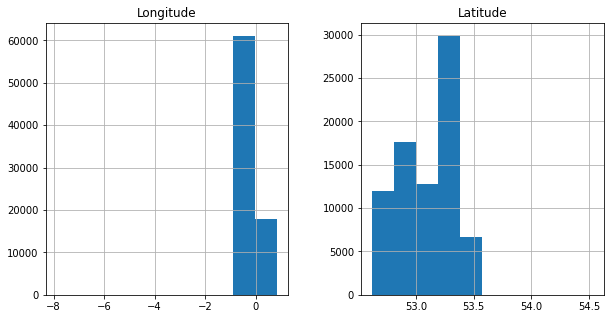


Prices numerical histograms


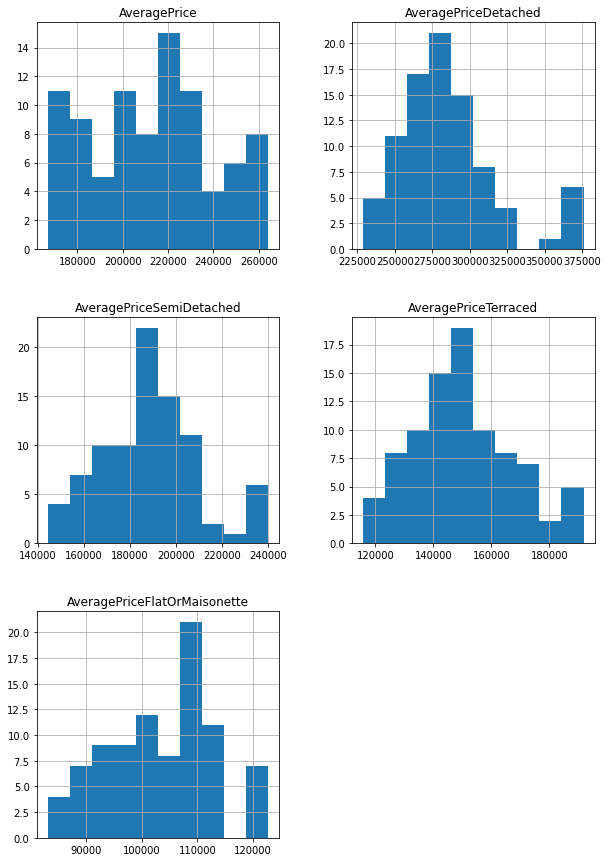

In [ ]:
print("Crimes numerical histograms")
plt.rc('font', size=10)
crimes[crimesNum].hist(figsize=(10,5))
plt.show()

print()
print("Prices numerical histograms")
plt.rc('font', size=10)
prices[pricesNum].hist(figsize=(10,15))
plt.show()

<p>Here we are going to check the outliers in price and their area. in particular, we will check the outliers that have a higher price.</p>

In [ ]:
for att in pricesNum:
  outsideTwo = prices[prices[att] > (prices[att].mean() + (2*prices[att].std()))]
  print(outsideTwo[['GeoName', att]])

Empty DataFrame
Columns: [GeoName, AveragePrice]
Index: []
           GeoName  AveragePriceDetached
6   South Kesteven                376069
14  South Kesteven                371899
22  South Kesteven                369449
30  South Kesteven                370216
38  South Kesteven                368267
46  South Kesteven                363336
54  South Kesteven                359809
           GeoName  AveragePriceSemiDetached
6   South Kesteven                    240156
14  South Kesteven                    236549
22  South Kesteven                    234170
30  South Kesteven                    234980
38  South Kesteven                    233559
46  South Kesteven                    231820
           GeoName  AveragePriceTerraced
6   South Kesteven                191838
14  South Kesteven                187692
22  South Kesteven                187202
30  South Kesteven                187524
38  South Kesteven                185592
Empty DataFrame
Columns: [GeoName, AveragePriceFlatO

<p>It seems that South Kesteven is the region with the highest average price per property in Lincolnshire. This will be interesting to see if we can extract any insight from this in the future. Despite it seeming like an outlier, we will keep this data.</p>

<h2>Categorical barplots</h2>

In [ ]:
def addCount(ax, isFloat=False):
    for p in ax.patches:
        if isFloat:
            ax.text(p.get_x() + p.get_width()/2.,
                    p.get_height(),
                    '{0:.2f}'.format(float(p.get_height())),
                    fontsize=12,
                    color='black',
                    ha='center',
                    va='bottom')
        else:
            ax.text(p.get_x() + p.get_width()/2.,
                    p.get_height(),
                    '{}'.format(int(p.get_height())),
                    fontsize=12,
                    color='black',
                    ha='center',
                    va='bottom')

<h4>Crime barplots</h4>

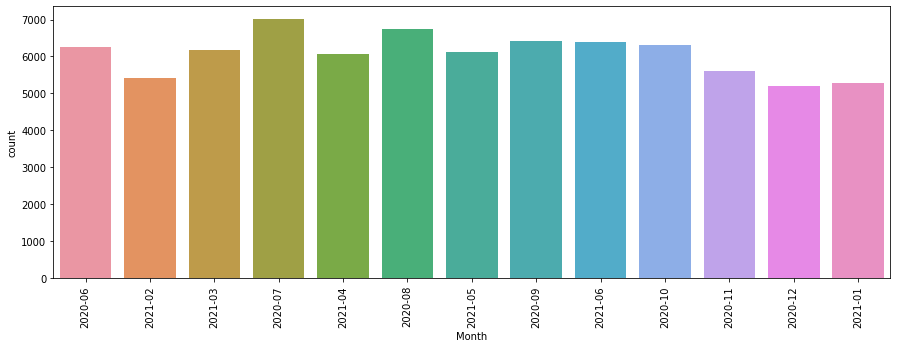

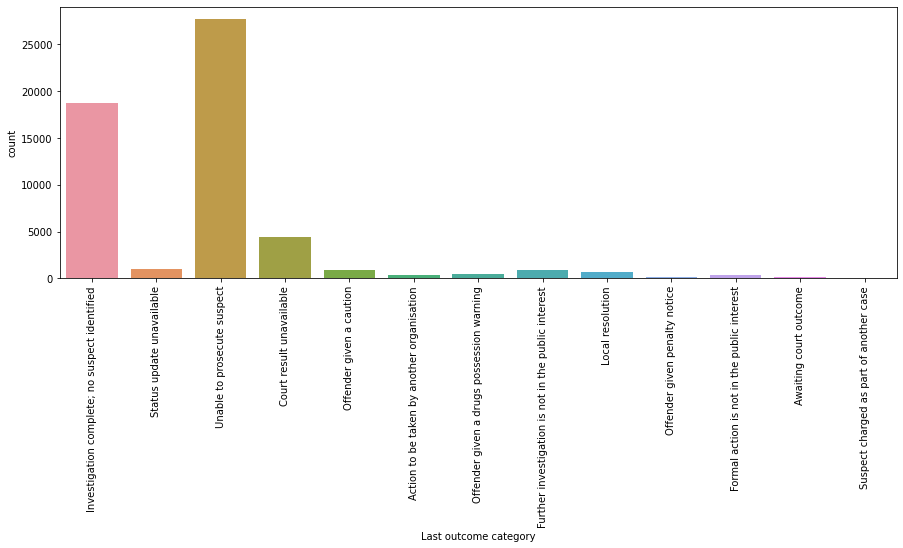

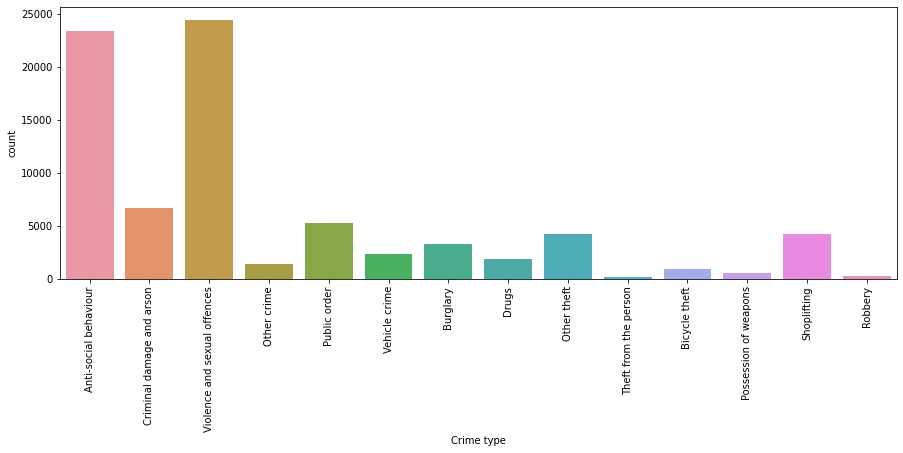

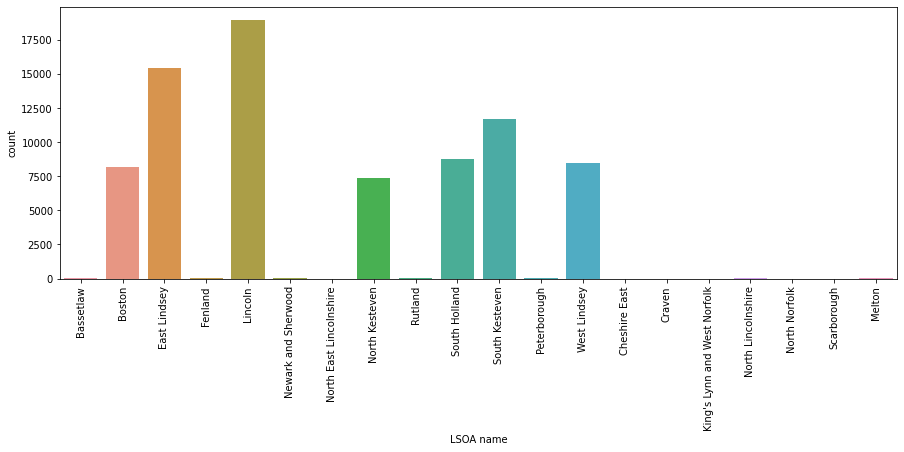

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
cols = ['Month', 'Last outcome category', 'Crime type', 'LSOA name']

for col in cols:
  plot = sns.countplot(x=col, data=crimes)
  plt.xticks(rotation=90)
  plt.show()

<p>We have decided to plot these attributes only because they are the ones with not too many unique values. We can see that there is a fairly uniform distribution of crimes amongst the months. However, in the other plots we can see that there is not an equal distribution per category. This will be something that we will have to take into account in the future.</p>

<h4>Prices barplots</h4>

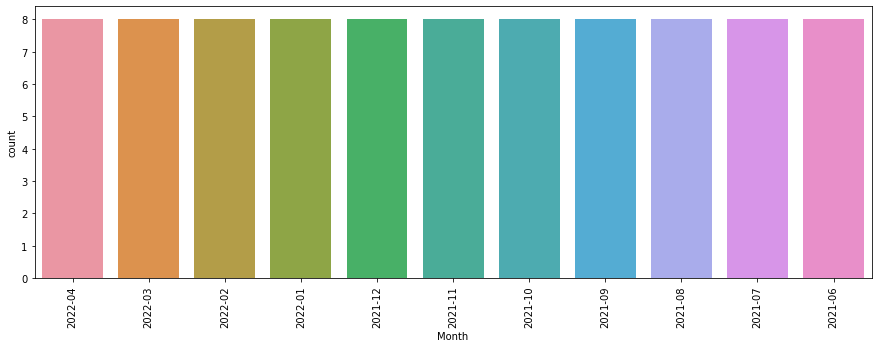

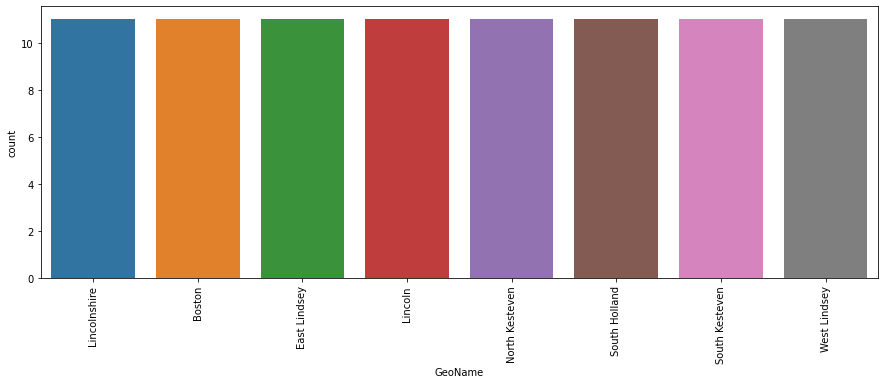

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
cols = ['Month', 'GeoName']

for col in cols:
  plot = sns.countplot(x=col, data=prices)
  plt.xticks(rotation=90)
  plt.show()

<p>As we can see we have an equal distribution of months and regions in the prices dataset. Next, we will check the "LSOA name" of the crimes dataset and the "GeoName" of the prices dataset to see if they are equal to be able to join them.</p>

In [ ]:
print("Crimes LSOA name values: ", crimes["LSOA name"].unique())
print("Prices GeoName values: ", prices["GeoName"].unique())

Crimes LSOA name values:  ['Bassetlaw' 'Boston' 'East Lindsey' 'Fenland' 'Lincoln'
 'Newark and Sherwood' 'North East Lincolnshire' 'North Kesteven'
 'Rutland' 'South Holland' 'South Kesteven' 'Peterborough' 'West Lindsey'
 'Cheshire East' 'Craven' nan "King's Lynn and West Norfolk"
 'North Lincolnshire' 'North Norfolk' 'Scarborough' 'Melton']
Prices GeoName values:  ['Lincolnshire' 'Boston' 'East Lindsey' 'Lincoln' 'North Kesteven'
 'South Holland' 'South Kesteven' 'West Lindsey']


<p>It looks like there are more regions in the crimes dataset than in the region dataset. What we will do is keep the intersection of both datasets instead of only keeping the values that are in the prices dataset. That way, if in the future we get new data with more regions, it will include it both datasets have the regions.</p>